In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import os
import pandas as pd
import torch
from dataset_preprocessing import TokenInfo
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import itertools
import pandas as pd
from tqdm import tqdm

## Importances

In [4]:
def get_importances():
    # print("this is wrong")
    dir = "./new_importances_data"
    imp_files = os.listdir(dir)
    imp_files = [file for file in imp_files if file.endswith(".pkl")]
    importances = {}
    for imp_file in tqdm(imp_files):
        importances.update(pd.read_pickle(f"{dir}/{imp_file}"))
    return importances

In [5]:
# imps = get_importances()

In [6]:
def get_avg_imporances(importances):
    avg_imps = [torch.zeros_like(imp) for imp in list(importances.values())[0]]
    for token, imps in tqdm(importances.items()):
        for i, layer_imps in enumerate(imps):
            avg_imps[i] += layer_imps / len(importances)
    # TODO think harder about averaging method
    return avg_imps

In [7]:
# avg_importances = get_avg_imporances(imps)

In [8]:
# pd.to_pickle(avg_importances, "./avg_importances.pkl")

In [9]:
avg_importances = pd.read_pickle("./avg_importances.pkl")

In [10]:
len(avg_importances)

24

## Model

In [11]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [13]:
vocab = tokenizer.get_vocab()
len(vocab)

50295

In [14]:
# tokenizer.decode(token_info.get_prefixes(top_tokens[1000][0], 9, 10)[0])

In [15]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    # torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

## Prune Model

In [16]:
from prunners import prune_mlps_individually
from importances import get_mlps

In [17]:
mlps = get_mlps(model)

In [18]:
len(mlps), len(avg_importances)

(24, 24)

In [19]:
avg_importances = dict(zip(mlps, avg_importances))

In [20]:
prune_mlps_individually(avg_importances, 0.5)

In [21]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

## New Dataset

In [22]:
from other_datasets import get_minipile, get_c4, get_wikitext2_filtered, get_bookcorpus
from dataset import get_baseline_dataset

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [23]:
minipile = get_minipile() # training dataset

# eval datasets
tiny_text = get_baseline_dataset()["test"]
c4 = get_c4(n=2000, do_split=False)
wikitext = get_wikitext2_filtered(n=2000, do_split=False)
bookcorpus = get_bookcorpus(n=2000, do_split=False)

reading pickle


/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for c4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/c4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## Metric Callback

In [24]:
from transformers import TrainerCallback

In [25]:
from evaluation import evaluate_on_nlp_tasks

In [26]:
class AccEvalCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.last_step=-1
    
    def on_evaluate(self, args, state, control, model, **kwargs):
        if state.global_step == self.last_step:
            return
        self.last_step = state.global_step
        train = model.training
        model.eval()
        with torch.no_grad():
            os.environ["TQDM_DISABLE"] = "1"
            eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)["results"]
            # import pdb; pdb.set_trace()
            eval_res = {k:v["acc,none"] for k,v in eval_res.items()}
            for k, v in eval_res.items():
                state.log_history.append(
                    {
                        k:v,
                        "epoch":state.epoch,
                        "step":state.global_step,
                    }
                )
            del os.environ['TQDM_DISABLE']
            print(eval_res)
        model.train(train)

## Train model

In [27]:
from peft import LoraConfig, PeftConfig
import transformers

In [28]:
from post_training import get_lora_config, get_training_arguments
from other_datasets import SFTTrainer_
from trl import SFTTrainer

In [29]:
lora_config = get_lora_config()
training_arguments = get_training_arguments("./tmp")

In [30]:
model.cuda();

In [31]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

In [32]:
train_data, eval_data = minipile["train"], minipile["test"]
eval_datasets = {
    "minipile":eval_data,
    "c4":c4,
    "wikitext":wikitext,
    "tiny_text":tiny_text,
    "bookcorpus":bookcorpus,
}

In [33]:
callbacks = [AccEvalCallback()]

In [34]:
tokenizer.pad_token = tokenizer.eos_token

In [35]:
training_arguments.save_strategy="no"

In [36]:
training_arguments.eval_steps = 100

In [37]:
trainer = SFTTrainer_(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_datasets,
    # eval_dataset={k:v.select(range(0, 100)) for k, v in eval_datasets.items()},
    # eval_dataset=eval_datasets["minipile"],
    peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    dataset_text_field="text",
    max_seq_length=1024, # tweak this
    # TODO: think harder about the datacollator
    # data_collator=transformers.DataCollatorForSeq2Seq(
    #     tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    # ),
    callbacks=callbacks,
)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

2024-03-04:09:40:23,049 WARNING  [logging.py:61] Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [38]:
train_res = trainer.train()

You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Minipile Loss,C4 Loss,Wikitext Loss,Tiny Text Loss,Bookcorpus Loss
100,2.996500,No log,3.056619,3.588732,4.293511,3.694662,5.999286
200,2.935400,No log,2.911403,3.448502,4.125601,3.543461,5.621758
300,2.876500,No log,2.872271,3.413776,4.093802,3.506790,5.571580
400,2.818100,No log,2.853395,3.397184,4.072480,3.487744,5.551630
500,2.917800,No log,2.842265,3.389716,4.063107,3.480459,5.551165
600,2.804700,No log,2.834789,3.383811,4.056701,3.473981,5.550017
700,2.756500,No log,2.829067,3.379772,4.051857,3.469270,5.547674
800,2.766800,No log,2.824801,3.376404,4.049644,3.465041,5.539046
900,2.747600,No log,2.821449,3.375025,4.049082,3.464143,5.543382
1000,2.815200,No log,2.818764,3.372971,4.047756,3.460757,5.550407


2024-03-04:10:25:51,228 WARNING  [huggingface.py:105] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-04:10:25:51,244 WARNING  [huggingface.py:315] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/100

{'hellaswag': 0.362, 'piqa': 0.712, 'boolq': 0.625, 'winogrande': 0.588}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [07:08<00:00, 23.32it/s]


{'hellaswag': 0.374, 'piqa': 0.708, 'boolq': 0.627, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [06:38<00:00, 25.09it/s]


{'hellaswag': 0.369, 'piqa': 0.713, 'boolq': 0.627, 'winogrande': 0.594}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 63%|████████████████████████              | 6319/10000 [04:18<02:28, 24.80it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (

{'hellaswag': 0.375, 'piqa': 0.71, 'boolq': 0.628, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [06:49<00:00, 24.40it/s]


{'hellaswag': 0.377, 'piqa': 0.714, 'boolq': 0.623, 'winogrande': 0.598}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [07:22<00:00, 22.60it/s]


{'hellaswag': 0.378, 'piqa': 0.709, 'boolq': 0.627, 'winogrande': 0.592}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:20<00:00, 31.20it/s]


{'hellaswag': 0.381, 'piqa': 0.711, 'boolq': 0.625, 'winogrande': 0.588}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████

{'hellaswag': 0.381, 'piqa': 0.716, 'boolq': 0.633, 'winogrande': 0.588}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:29<00:00, 30.30it/s]


{'hellaswag': 0.381, 'piqa': 0.716, 'boolq': 0.631, 'winogrande': 0.592}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [07:59<00:00, 20.87it/s]


{'hellaswag': 0.38, 'piqa': 0.714, 'boolq': 0.632, 'winogrande': 0.592}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [39]:
pd.to_pickle(trainer.state, "./tmp/new_dataset_trainer_state_llm_pruner_style_0.5ratio.pkl")

In [40]:
trainer_state = trainer.state
pd.DataFrame(trainer_state.log_history).tail()

,loss,learning_rate,epoch,step,eval_minipile_loss,eval_minipile_runtime,eval_minipile_samples_per_second,eval_minipile_steps_per_second,hellaswag,piqa,...,eval_tiny_text_steps_per_second,eval_bookcorpus_loss,eval_bookcorpus_runtime,eval_bookcorpus_samples_per_second,eval_bookcorpus_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
307,2.7955,2.298851e-06,1.96,1630,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,2.8023,1.660281e-06,1.97,1640,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,2.8277,1.021711e-06,1.98,1650,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,2.7417,3.831418e-07,1.99,1660,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,NaN,NaN,2.00,1666,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,58231.1959,1.717,0.029,5.366495e+17,2.86741


### Evaluation

In [41]:
from evaluation import evaluate_on_nlp_tasks

In [42]:
model.eval();

In [43]:
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=300)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████████████████| 3000/3000 [01:35<00:00, 31.34it/s]
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [44]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.38333333333333336,
  'acc_norm,none': 0.45666666666666667,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.7033333333333334,
  'acc_norm,none': 0.7066666666666667,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.6233333333333333, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.57, 'alias': 'winogrande'}}

In [45]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████████████████| 10000/10000 [05:52<00:00, 28.33it/s]
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [46]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.38, 'acc_norm,none': 0.486, 'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.714, 'acc_norm,none': 0.703, 'alias': 'piqa'},
 'boolq': {'acc,none': 0.633, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.592, 'alias': 'winogrande'}}

## Save

In [47]:
model.cpu();

In [48]:
torch.save(model.state_dict(), "./tmp/new_dataset_model_llm_prunner_style_0.5ratio_state_dict")

### Looking at stats

In [50]:
df = pd.DataFrame(trainer_state.log_history)

In [52]:
metrics_df = df[["step", "hellaswag", "piqa", "boolq", "winogrande"]]

<Axes: xlabel='step'>

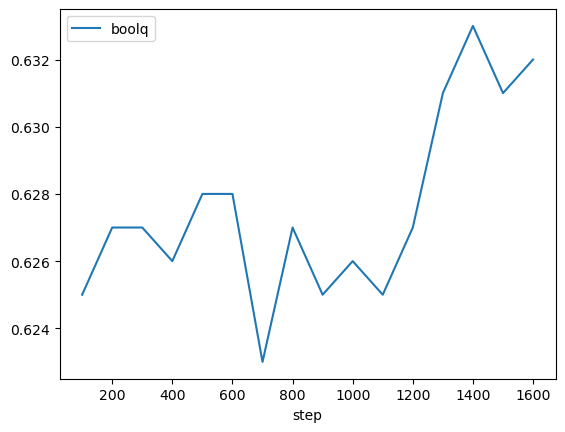

In [53]:
metrics_df[["step", "boolq"]].dropna().set_index("step").plot()

<Axes: xlabel='step'>

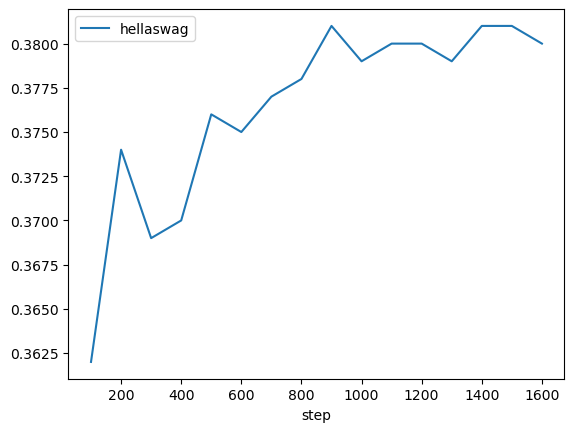

In [54]:
metrics_df[["step", "hellaswag"]].dropna().set_index("step").plot()

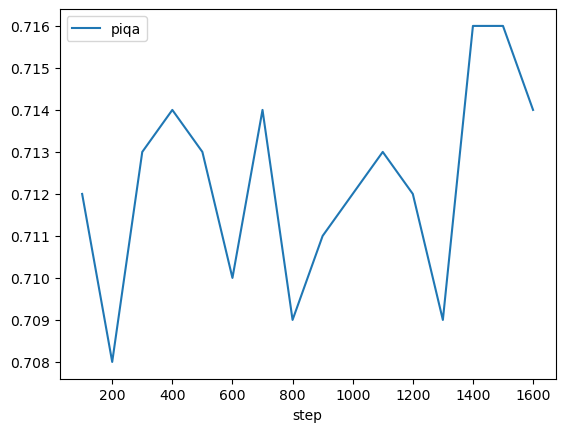

In [55]:
metrics_df = df[["step", "piqa"]].dropna().set_index("step").plot()

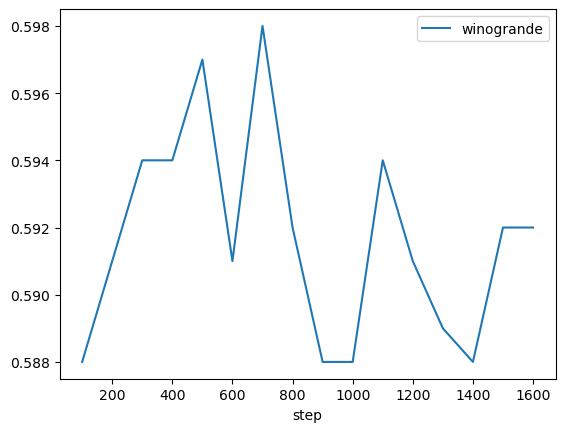

In [56]:
metrics_df = df[["step", "winogrande"]].dropna().set_index("step").plot()